In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<h1 align="center"> Somewhat Informed </h1>
<h3 align="center"> Christine Zhang </h3>

---

In [83]:
import numpy as np
import pandas as pd
import scipy as sp
import pickle
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

### Lung One-Hot

---

In [3]:
auc_pd = pd.read_csv('dataset1.csv', skiprows = [0,1], sep =",", 
                          names = ["Cclid", "Cellline", "Sites", "Histology", "Subhistology", "Culture", "SNP", "AUC"])
auc = auc_pd.as_matrix()
auc_pd[auc_pd["Sites"]=="lung"]["Subhistology"].drop_duplicates()

41              non_small_cell_carcinoma
46               squamous_cell_carcinoma
47                        adenocarcinoma
55                                    NS
61                  small_cell_carcinoma
114        mixed_adenosquamous_carcinoma
117                 large_cell_carcinoma
289    bronchioloalveolar_adenocarcinoma
319             mucoepidermoid_carcinoma
Name: Subhistology, dtype: object

In [4]:
for index, row in auc_pd.iterrows():
    if auc_pd.loc[index,"Sites"] == "lung":
        if auc_pd.loc[index,"Subhistology"] == "bronchioloalveolar_adenocarcinoma" or auc_pd.loc[index,"Subhistology"] == "mixed_adenosquamous_carcinoma":
            auc_pd.loc[index,"Sites"] = "adenocarcinoma"
        elif auc_pd.loc[index,"Subhistology"] == "mucoepidermoid_carcinoma":
            auc_pd.loc[index,"Sites"] = "squamous_cell_carcinoma"
        else:
            auc_pd.loc[index,"Sites"] = auc_pd.loc[index,"Subhistology"]
auc_pd.head()

,Cclid,Cellline,Sites,Histology,Subhistology,Culture,SNP,AUC
0,3,5637,urinary_tract,carcinoma,NS,RPMI001,SNP-matched-reference,2.473
1,7,22RV1,prostate,carcinoma,NS,RPMI001,SNP-matched-reference,2.142
2,10,42MGBA,central_nervous_system,glioma,astrocytoma_Grade_IV,RPMIMEM001,SNP-matched-reference,3.380
3,15,647V,urinary_tract,carcinoma,transitional_cell_carcinoma,DMEM011,SNP-matched-reference,3.374
4,16,769P,kidney,carcinoma,clear_cell_renal_cell_carcinoma,RPMI001,SNP-matched-reference,3.123


In [5]:
file_name = "auc_pd"
with open(file_name,'wb') as my_file_obj:
    pickle.dump(auc_pd,my_file_obj)

In [6]:
file_name = "master_no_auc"
file_object = open(file_name,'r')  
master_no_auc_pd = pickle.load(file_object)
print np.shape(master_no_auc_pd)
master_no_auc_pd.head()

(472, 24704)


Entrez_id,1,503538,29974,2,144571,144568,3,53947,51146,100506677,...,6608_y,8522_y,2885_y,2161_y,27255_y,23072_y,6725_y,9149_y,6241_y,8301_y
3,-0.0324,-0.0324,-0.4928,-0.0657,-0.0657,-0.0657,-0.0657,-0.0390,0.0518,0.4291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.0762,-0.0762,-0.0025,0.4486,0.4486,0.4486,0.4486,-0.0574,-0.0303,-0.0712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0346,0.0346,-0.0522,-0.3816,-0.3816,-0.3816,-0.3816,-0.0155,-0.2675,-0.7758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.2934,0.2934,-0.3050,0.1603,0.1603,0.1603,0.1603,-0.2881,0.2831,0.0613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0463,0.0463,0.0436,-0.0112,-0.0112,-0.0112,-0.0112,0.0834,0.0468,0.0528,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# encode categorical variables
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array

# apply one hot encoding
def one_hot (dataframe): 
    sites_lst = []
    for index, val in enumerate(auc_pd["Cclid"]):
        if str(val) in list(dataframe.index):
            sites_lst.append(auc_pd.loc[index,"Sites"])
    dataframe.loc[:,"Sites"] = sites_lst
    
    # Categorical columns for use in one-hot encoder
    categorical = (dataframe.dtypes.values != np.dtype('float64'))

    # Encode all labels
    dataframe = dataframe.apply(encode_categorical)
    dataframe_np = dataframe.as_matrix()
    return dataframe_np, dataframe

In [31]:
master_no_auc_onehot, master_no_auc_onehot_pd = one_hot (master_no_auc_pd)
master_no_auc_onehot_pd.head()

Entrez_id,1,503538,29974,2,144571,144568,3,53947,51146,100506677,...,8522_y,2885_y,2161_y,27255_y,23072_y,6725_y,9149_y,6241_y,8301_y,Sites
3,-0.0324,-0.0324,-0.4928,-0.0657,-0.0657,-0.0657,-0.0657,-0.0390,0.0518,0.4291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26
7,-0.0762,-0.0762,-0.0025,0.4486,0.4486,0.4486,0.4486,-0.0574,-0.0303,-0.0712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
10,0.0346,0.0346,-0.0522,-0.3816,-0.3816,-0.3816,-0.3816,-0.0155,-0.2675,-0.7758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
15,0.2934,0.2934,-0.3050,0.1603,0.1603,0.1603,0.1603,-0.2881,0.2831,0.0613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26
16,0.0463,0.0463,0.0436,-0.0112,-0.0112,-0.0112,-0.0112,0.0834,0.0468,0.0528,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


In [9]:
file_name = "master_auc"
file_object = open(file_name,'r')  
master_auc_pd = pickle.load(file_object)
master_auc = master_auc_pd.as_matrix()
master_auc = master_auc.reshape([472,1])
print np.shape(master_auc)
master_auc_pd.head()

(472, 1)


3     2.473
7     2.142
10    3.380
15    3.374
16    3.123
Name: AUC, dtype: float64

In [10]:
linreg = LinearRegression()
svr_rbf = SVR(kernel = "rbf")
svr_lin = SVR(kernel = "linear")
rf = RandomForestRegressor()

# test naive models
def test_model (model):
    clf = model
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    r2 = clf.score(x_test, y_test)
    return y_pred, r2

def draw_plot (ax, y_pred, title, y_score):
    y_pred = y_pred.flatten()
    ax.scatter(y_pred, y_test)
    ax.plot(np.unique(y_pred), np.poly1d(np.polyfit(y_pred, y_test, 1))(np.unique(y_pred)))
    ax.set_title("%s r2 accuracy: %s" %(title, round(y_score, 3)))
    ax.set_xlabel("Predicted AUC")
    ax.set_ylabel("Actual AUC")
    return plt

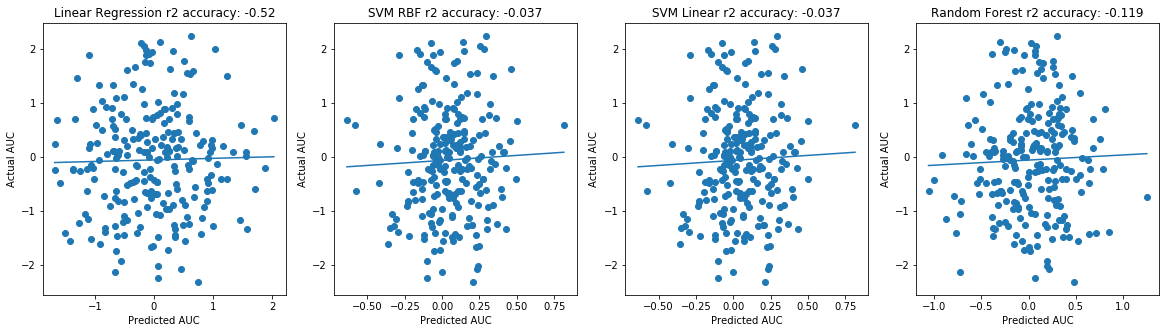

In [37]:
master_no_auc_onehot_scaled = preprocessing.scale(master_no_auc_onehot)
master_auc_scaled = preprocessing.scale(master_auc)

x_train, x_test, y_train, y_test = train_test_split(master_no_auc_onehot_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred, r2_linreg = test_model (linreg)
svr_rbf_y_pred, r2_svr_rbf = test_model (svr_rbf)
svr_lin_y_pred, r2_svr_lin = test_model (svr_rbf)
rf_y_pred, r2_rf = test_model (rf)

fig_all, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0] = draw_plot (ax[0], linreg_y_pred, "Linear Regression", r2_linreg)
ax[1] = draw_plot (ax[1], svr_rbf_y_pred, "SVM RBF", r2_svr_rbf)
ax[2] = draw_plot (ax[2], svr_lin_y_pred, "SVM Linear", r2_svr_lin)
ax[3] = draw_plot (ax[3], rf_y_pred, "Random Forest", r2_rf)

In [38]:
score_df = pd.DataFrame({'Linear Regression': [r2_linreg],
                         'SVM RBF': [r2_svr_rbf],
                         'SVM Linear': [r2_svr_lin],
                         'Random Forest': [r2_rf]}, 
                       index=["Somewhat Informed"])
score_df

,Linear Regression,Random Forest,SVM Linear,SVM RBF
Somewhat Informed,-0.51966,-0.119126,-0.037146,-0.037146


### Feature Selection

---

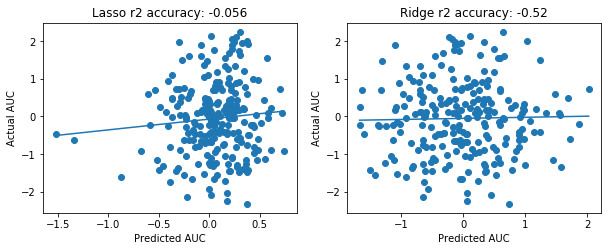

In [39]:
x_train, x_test, y_train, y_test = train_test_split(master_no_auc_onehot_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
y_pred_lasso, r2_lasso = test_model (lasso)
y_pred_ridge, r2_ridge = test_model (ridge)

fig_all, ax = plt.subplots(1, 2, figsize=(10, 3.5))
ax[0] = draw_plot (ax[0], y_pred_lasso, "Lasso", r2_lasso)
ax[1] = draw_plot (ax[1], y_pred_ridge, "Ridge", r2_ridge)

In [40]:
score_df = pd.DataFrame({'Linear Regression': [r2_linreg],
                         'SVM RBF': [r2_svr_rbf],
                         'SVM Linear': [r2_svr_lin],
                         'Random Forest': [r2_rf],
                         'Lasso': [r2_lasso],
                         'Ridge': [r2_ridge]}, 
                       index=["All"])
score_df

,Lasso,Linear Regression,Random Forest,Ridge,SVM Linear,SVM RBF
All,-0.056395,-0.51966,-0.119126,-0.519796,-0.037146,-0.037146


### Predictors Chosen by Lasso

---

In [41]:
lasso.fit(master_no_auc_onehot, master_auc)
index_lst = []
for index, coef in enumerate(lasso.coef_):
    if coef != 0.0:
        index_lst.append(index)
master_no_auc_pd.iloc[:,index_lst].head()

Entrez_id,56899,1016,1030_x,51716,57055,2064_x,5789_x,729201,220115,7227_x,51198,340357,Sites
3,0.2487,0.3658,0.3753,-3.2431,-2.2221,0.5999,0.3753,0.0068,-0.5911,0.0842,0.3753,-0.5158,urinary_tract
7,0.4557,-0.0418,-0.0383,-1.8994,-1.0085,-0.0667,-0.0383,-0.0164,-0.0436,-0.0439,-0.0383,-1.8931,prostate
10,-0.3138,0.6383,-4.4275,-2.7610,-4.9916,-0.3066,0.0883,-0.5324,-2.4486,0.3513,-2.7112,-0.1203,central_nervous_system
15,0.8370,1.1775,-0.2346,-2.8088,-5.4647,0.0841,-0.2620,0.0758,-0.2664,-0.1944,-0.2346,-0.2273,urinary_tract
16,0.0415,0.0195,-0.8478,-1.4090,-4.0668,0.1070,0.0243,0.0037,-2.2805,0.5550,-0.8478,0.0159,kidney


### Random Forest Binary

---

In [42]:
master_no_auc_sites_pd = master_no_auc_pd
sites_lst = []
for index, val in enumerate(auc_pd["Cclid"]):
    if str(val) in list(master_no_auc_pd.index):
        sites_lst.append(auc_pd.loc[index,"Sites"])
master_no_auc_sites_pd["Sites"] = sites_lst

In [54]:
# apply binary one hot encoding
def binary_one_hot (dataframe): 
    sites_lst = []
    for index, val in enumerate(auc_pd["Cclid"]):
        if str(val) in list(dataframe.index):
            sites_lst.append(auc_pd.loc[index,"Sites"])
    dataframe["Sites"] = sites_lst
    
    dataframe_binary_pd = pd.get_dummies(dataframe)
    dataframe_binary = dataframe_binary_pd.as_matrix()

    return dataframe_binary, dataframe_binary_pd

In [57]:
master_no_auc_binary, master_no_auc_binary_pd = binary_one_hot(master_no_auc_sites_pd)
master_no_auc_binary_pd.head()

,1,503538,29974,2,144571,144568,3,53947,51146,100506677,...,Sites_prostate,Sites_salivary_gland,Sites_skin,Sites_small_cell_carcinoma,Sites_soft_tissue,Sites_squamous_cell_carcinoma,Sites_stomach,Sites_thyroid,Sites_upper_aerodigestive_tract,Sites_urinary_tract
3,-0.0324,-0.0324,-0.4928,-0.0657,-0.0657,-0.0657,-0.0657,-0.0390,0.0518,0.4291,...,0,0,0,0,0,0,0,0,0,1
7,-0.0762,-0.0762,-0.0025,0.4486,0.4486,0.4486,0.4486,-0.0574,-0.0303,-0.0712,...,1,0,0,0,0,0,0,0,0,0
10,0.0346,0.0346,-0.0522,-0.3816,-0.3816,-0.3816,-0.3816,-0.0155,-0.2675,-0.7758,...,0,0,0,0,0,0,0,0,0,0
15,0.2934,0.2934,-0.3050,0.1603,0.1603,0.1603,0.1603,-0.2881,0.2831,0.0613,...,0,0,0,0,0,0,0,0,0,1
16,0.0463,0.0463,0.0436,-0.0112,-0.0112,-0.0112,-0.0112,0.0834,0.0468,0.0528,...,0,0,0,0,0,0,0,0,0,0


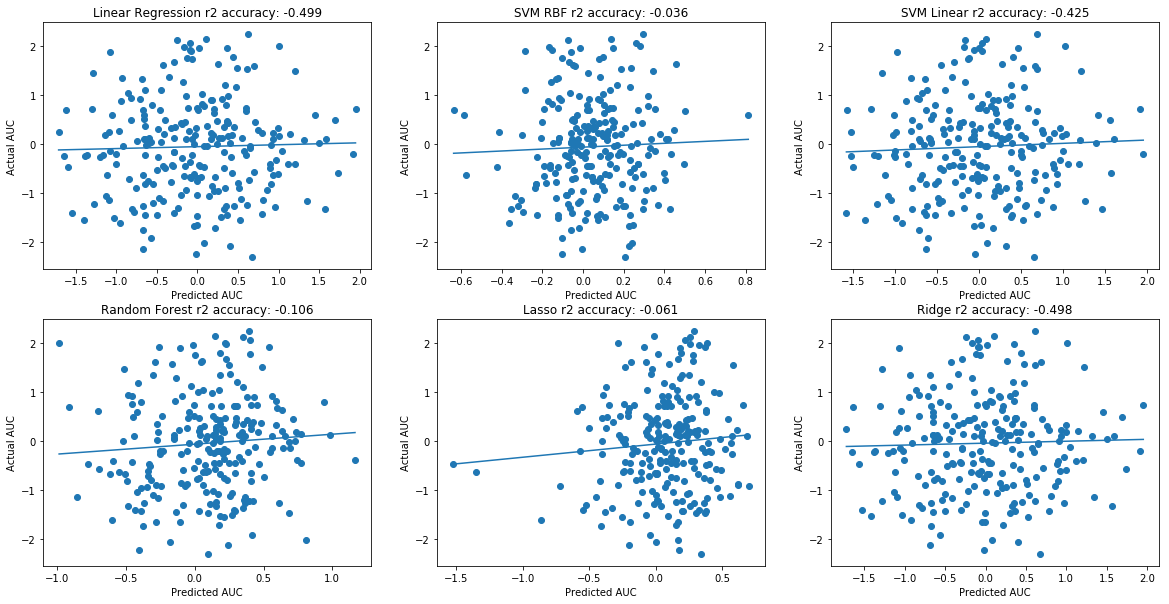

In [58]:
master_no_auc_binary = master_no_auc_binary_pd.as_matrix()

master_no_auc_binary_scaled = preprocessing.scale(master_no_auc_binary)
master_auc_scaled = preprocessing.scale(master_auc)

x_train, x_test, y_train, y_test = train_test_split(master_no_auc_binary_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_binary_y_pred, r2_linreg_binary = test_model (linreg)
svr_rbf_binary_y_pred, r2_svr_rbf_binary = test_model (svr_rbf)
svr_lin_binary_y_pred, r2_svr_lin_binary = test_model (svr_lin)
rf_binary_y_pred, r2_rf_binary = test_model (rf)
y_pred_lasso_binary, r2_lasso_binary = test_model (lasso)
y_pred_ridge_binary, r2_ridge_binary = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_binary_y_pred, "Linear Regression", r2_linreg_binary)
ax[0,1] = draw_plot (ax[0,1], svr_rbf_binary_y_pred, "SVM RBF", r2_svr_rbf_binary)
ax[0,2] = draw_plot (ax[0,2], svr_lin_binary_y_pred, "SVM Linear", r2_svr_lin_binary)
ax[1,0] = draw_plot (ax[1,0], rf_binary_y_pred, "Random Forest", r2_rf_binary)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_binary, "Lasso", r2_lasso_binary)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_binary, "Ridge", r2_ridge_binary)

In [59]:
lasso = linear_model.Lasso(alpha=0.1)
ridge = linear_model.Ridge(alpha=0.1)

In [60]:
lasso.fit(master_no_auc_binary, master_auc)
index_lst = []
for index, coef in enumerate(lasso.coef_):
    if coef != 0.0:
        index_lst.append(index)
master_no_auc_binary_pd.iloc[:,index_lst].head()

,56899,1016,1030_x,51716,57055,2064_x,5789_x,729201,220115,7227_x,51198,340357
3,0.2487,0.3658,0.3753,-3.2431,-2.2221,0.5999,0.3753,0.0068,-0.5911,0.0842,0.3753,-0.5158
7,0.4557,-0.0418,-0.0383,-1.8994,-1.0085,-0.0667,-0.0383,-0.0164,-0.0436,-0.0439,-0.0383,-1.8931
10,-0.3138,0.6383,-4.4275,-2.7610,-4.9916,-0.3066,0.0883,-0.5324,-2.4486,0.3513,-2.7112,-0.1203
15,0.8370,1.1775,-0.2346,-2.8088,-5.4647,0.0841,-0.2620,0.0758,-0.2664,-0.1944,-0.2346,-0.2273
16,0.0415,0.0195,-0.8478,-1.4090,-4.0668,0.1070,0.0243,0.0037,-2.2805,0.5550,-0.8478,0.0159


### Just Mutation

---

In [61]:
file_name = "mutation_pd"
file_object = open(file_name,'r')  
mutation_clean_pd = pickle.load(file_object)
print np.shape(mutation_clean_pd)
mutation_pd = mutation_clean_pd

(472, 1530)


In [62]:
mutation, mutation_pd = one_hot (mutation_pd)
mutation_pd.head()

Entrez_id,890,4478,2317,6790,120892,4342,4739,6498,8313,10298,...,8522,2885,2161,27255,23072,6725,9149,6241,8301,Sites
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


In [63]:
mutation_binary, mutation_binary_pd = binary_one_hot (mutation_pd)
mutation_binary_pd.head()

,890,4478,2317,6790,120892,4342,4739,6498,8313,10298,...,Sites_prostate,Sites_salivary_gland,Sites_skin,Sites_small_cell_carcinoma,Sites_soft_tissue,Sites_squamous_cell_carcinoma,Sites_stomach,Sites_thyroid,Sites_upper_aerodigestive_tract,Sites_urinary_tract
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


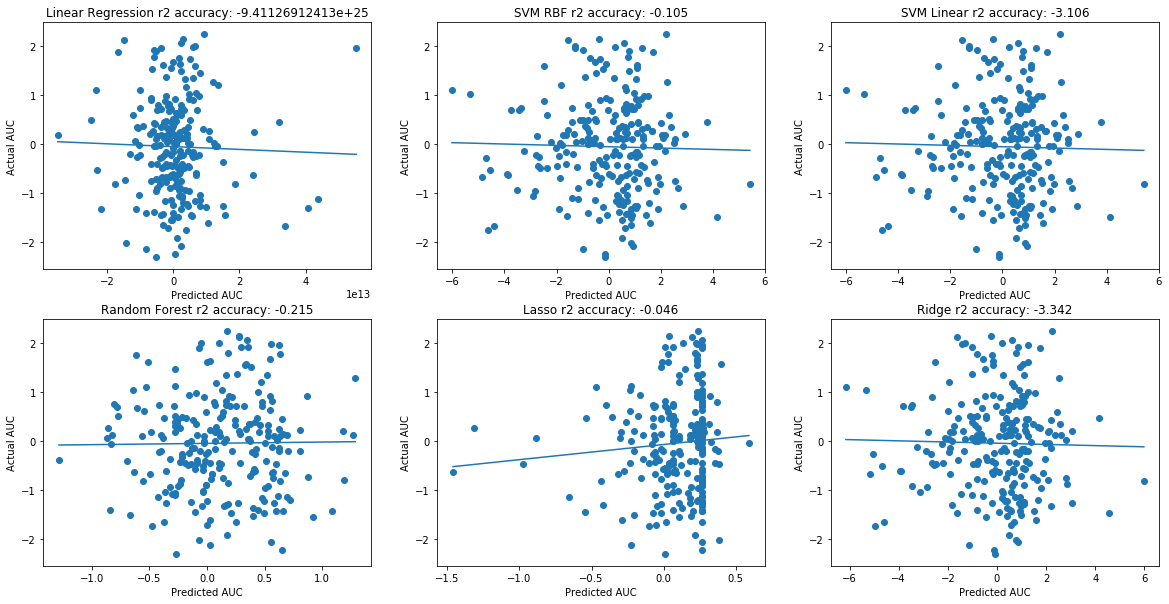

In [24]:
mutation_scaled = preprocessing.scale(mutation)

x_train, x_test, y_train, y_test = train_test_split(mutation_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred_mut, r2_linreg_mut = test_model (linreg)
svr_y_pred_mut, r2_svr_rbf_mut = test_model (svr_rbf)
svr_y_pred_mut, r2_svr_lin_mut = test_model (svr_lin)
rf_y_pred_mut, r2_rf_mut = test_model (rf)
y_pred_lasso_mut, r2_lasso_mut = test_model (lasso)
y_pred_ridge_mut, r2_ridge_mut = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred_mut, "Linear Regression", r2_linreg_mut)
ax[0,1] = draw_plot (ax[0,1], svr_y_pred_mut, "SVM RBF", r2_svr_rbf_mut)
ax[0,2] = draw_plot (ax[0,2], svr_y_pred_mut, "SVM Linear", r2_svr_lin_mut)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred_mut, "Random Forest", r2_rf_mut)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_mut, "Lasso", r2_lasso_mut)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_mut, "Ridge", r2_ridge_mut)

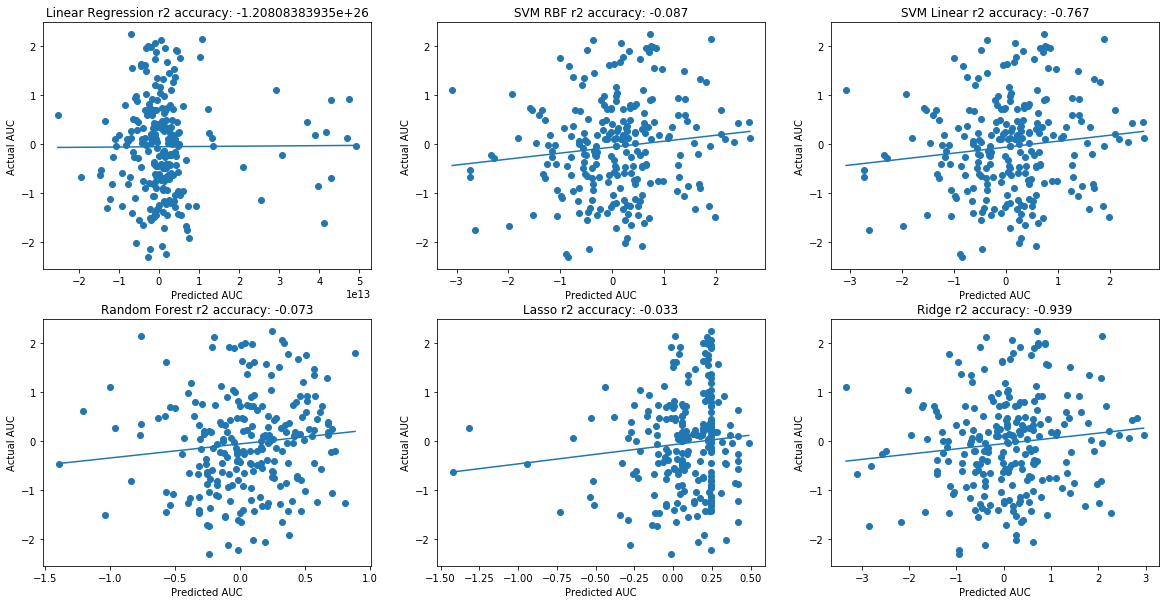

In [64]:
mutation_binary_scaled = preprocessing.scale(mutation_binary)

x_train, x_test, y_train, y_test = train_test_split(mutation_binary_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred_mut_binary, r2_linreg_mut_binary = test_model (linreg)
svr_y_pred_mut_binary, r2_svr_rbf_mut_binary = test_model (svr_rbf)
svr_y_pred_mut_binary, r2_svr_lin_mut_binary = test_model (svr_lin)
rf_y_pred_mut_binary, r2_rf_mut_binary = test_model (rf)
y_pred_lasso_mut_binary, r2_lasso_mut_binary = test_model (lasso)
y_pred_ridge_mut_binary, r2_ridge_mut_binary = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred_mut_binary, "Linear Regression", r2_linreg_mut_binary)
ax[0,1] = draw_plot (ax[0,1], svr_y_pred_mut_binary, "SVM RBF", r2_svr_rbf_mut_binary)
ax[0,2] = draw_plot (ax[0,2], svr_y_pred_mut_binary, "SVM Linear", r2_svr_lin_mut_binary)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred_mut_binary, "Random Forest", r2_rf_mut_binary)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_mut_binary, "Lasso", r2_lasso_mut_binary)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_mut_binary, "Ridge", r2_ridge_mut_binary)

### Just Copy Number

---

In [67]:
file_name = "copynum_pd"
file_object = open(file_name,'r')  
copynum_clean_pd = pickle.load(file_object)
print np.shape(copynum_clean_pd)
copynum_pd = copynum_clean_pd

(472, 23174)


In [26]:
copynum, copynum_pd = one_hot (copynum_pd)
copynum_pd.head()

Entrez_id,1,503538,29974,2,144571,144568,3,53947,51146,100506677,...,91149,91316,91450,91948,92249,92973,93432,93622,96610,Sites
3,-0.0324,-0.0324,-0.4928,-0.0657,-0.0657,-0.0657,-0.0657,-0.0390,0.0518,0.4291,...,0.0865,0.3492,-0.0328,0.0134,0.0068,0.3753,0.3447,-0.5221,0.3231,26
7,-0.0762,-0.0762,-0.0025,0.4486,0.4486,0.4486,0.4486,-0.0574,-0.0303,-0.0712,...,-0.9972,0.0626,-0.0705,-0.0705,-0.0164,-0.0542,0.4749,-0.0770,0.0626,17
10,0.0346,0.0346,-0.0522,-0.3816,-0.3816,-0.3816,-0.3816,-0.0155,-0.2675,-0.7758,...,0.3231,-0.0227,0.0947,0.1348,0.3855,-0.2897,-0.4246,-0.0198,0.0390,6
15,0.2934,0.2934,-0.3050,0.1603,0.1603,0.1603,0.1603,-0.2881,0.2831,0.0613,...,-0.2420,-0.4661,-0.3308,-0.3570,-0.0185,-0.2710,-0.4542,-0.3288,-0.4152,26
16,0.0463,0.0463,0.0436,-0.0112,-0.0112,-0.0112,-0.0112,0.0834,0.0468,0.0528,...,0.0290,0.1263,0.0286,0.0330,0.0037,0.0684,0.0400,0.0982,0.1263,8


In [69]:
copynum_binary, copynum_binary_pd = binary_one_hot (copynum_pd)
copynum_binary_pd.head()

,1,503538,29974,2,144571,144568,3,53947,51146,100506677,...,Sites_prostate,Sites_salivary_gland,Sites_skin,Sites_small_cell_carcinoma,Sites_soft_tissue,Sites_squamous_cell_carcinoma,Sites_stomach,Sites_thyroid,Sites_upper_aerodigestive_tract,Sites_urinary_tract
3,-0.0324,-0.0324,-0.4928,-0.0657,-0.0657,-0.0657,-0.0657,-0.0390,0.0518,0.4291,...,0,0,0,0,0,0,0,0,0,1
7,-0.0762,-0.0762,-0.0025,0.4486,0.4486,0.4486,0.4486,-0.0574,-0.0303,-0.0712,...,1,0,0,0,0,0,0,0,0,0
10,0.0346,0.0346,-0.0522,-0.3816,-0.3816,-0.3816,-0.3816,-0.0155,-0.2675,-0.7758,...,0,0,0,0,0,0,0,0,0,0
15,0.2934,0.2934,-0.3050,0.1603,0.1603,0.1603,0.1603,-0.2881,0.2831,0.0613,...,0,0,0,0,0,0,0,0,0,1
16,0.0463,0.0463,0.0436,-0.0112,-0.0112,-0.0112,-0.0112,0.0834,0.0468,0.0528,...,0,0,0,0,0,0,0,0,0,0


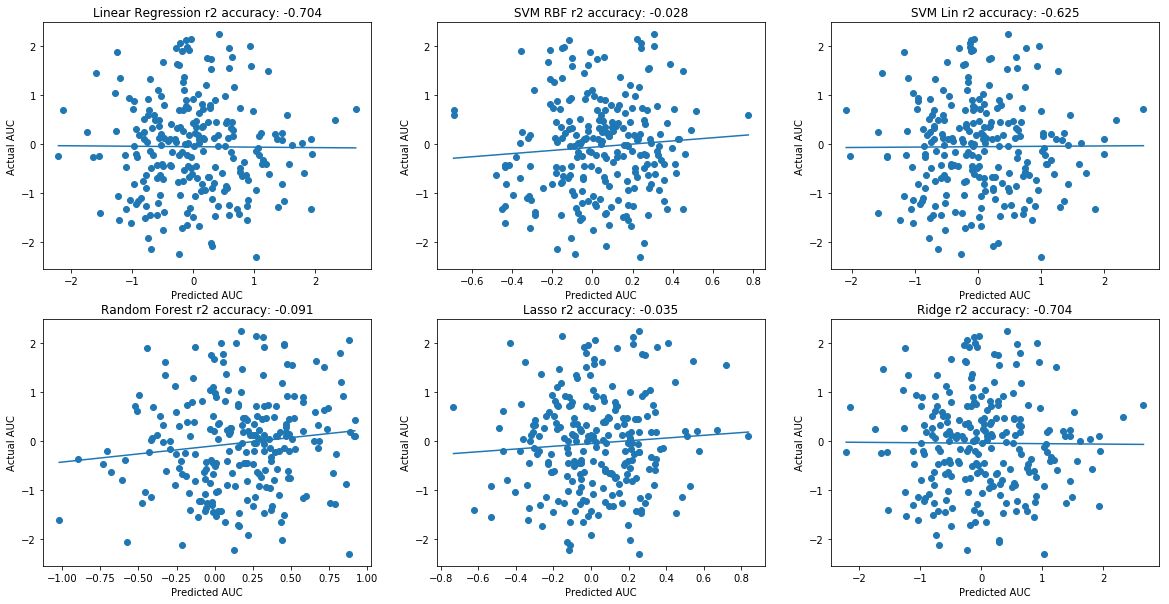

In [27]:
cn_scaled = preprocessing.scale(copynum)

x_train, x_test, y_train, y_test = train_test_split(cn_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred_cn, r2_linreg_cn = test_model (linreg)
svr_rbf_y_pred_cn, r2_svr_rbf_cn = test_model (svr_rbf)
svr_lin_y_pred_cn, r2_svr_lin_cn = test_model (svr_lin)
rf_y_pred_cn, r2_rf_cn = test_model (rf)
y_pred_lasso_cn, r2_lasso_cn = test_model (lasso)
y_pred_ridge_cn, r2_ridge_cn = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred_cn, "Linear Regression", r2_linreg_cn)
ax[0,1] = draw_plot (ax[0,1], svr_rbf_y_pred_cn, "SVM RBF", r2_svr_rbf_cn)
ax[0,2] = draw_plot (ax[0,2], svr_lin_y_pred_cn, "SVM Lin", r2_svr_lin_cn)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred_cn, "Random Forest", r2_rf_cn)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_cn, "Lasso", r2_lasso_cn)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_cn, "Ridge", r2_ridge_cn)

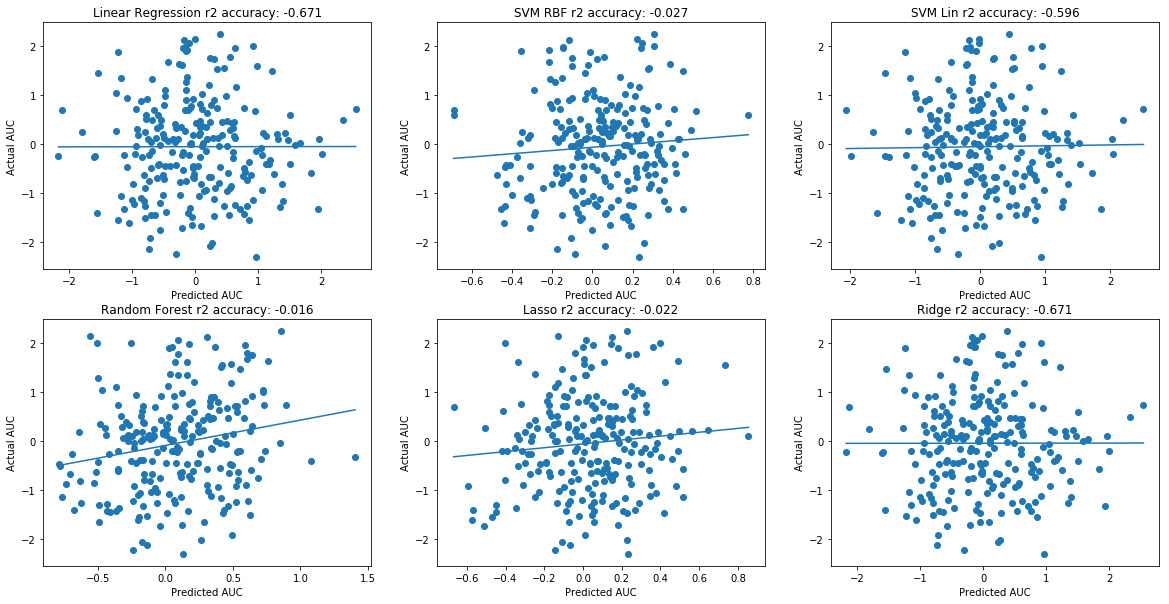

In [70]:
cn_scaled = preprocessing.scale(copynum_binary)

x_train, x_test, y_train, y_test = train_test_split(cn_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred_cn_binary, r2_linreg_cn_binary = test_model (linreg)
svr_rbf_y_pred_cn_binary, r2_svr_rbf_cn_binary = test_model (svr_rbf)
svr_lin_y_pred_cn_binary, r2_svr_lin_cn_binary = test_model (svr_lin)
rf_y_pred_cn_binary, r2_rf_cn_binary = test_model (rf)
y_pred_lasso_cn_binary, r2_lasso_cn_binary = test_model (lasso)
y_pred_ridge_cn_binary, r2_ridge_cn_binary = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred_cn_binary, "Linear Regression", r2_linreg_cn_binary)
ax[0,1] = draw_plot (ax[0,1], svr_rbf_y_pred_cn_binary, "SVM RBF", r2_svr_rbf_cn_binary)
ax[0,2] = draw_plot (ax[0,2], svr_lin_y_pred_cn_binary, "SVM Lin", r2_svr_lin_cn_binary)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred_cn_binary, "Random Forest", r2_rf_cn_binary)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_cn_binary, "Lasso", r2_lasso_cn_binary)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_cn_binary, "Ridge", r2_ridge_cn_binary)

### PCA

---

In [84]:
master_cclid_onehot, master_cclid_onehot_pd = one_hot (master_no_auc_pd)
master_cclid_binary, master_cclid_binary_pd = binary_one_hot (master_no_auc_pd)

In [95]:
def PCA_apply (dataframe):
    dataframe = dataframe.transpose()
    master_cclid = dataframe.as_matrix()
    pca = PCA(n_components=10)
    scaled_data = preprocessing.scale(master_cclid)
    pca.fit(scaled_data)    
    pca.transform(scaled_data)
    pca_components_pd = pd.DataFrame(data = pca.components_, columns = dataframe.columns.values).transpose()
    pca_components = pca_components_pd.as_matrix()
    print "Amount of Variance explained by each component: ", pca.explained_variance_ratio_
    print "Total Variance Captured", np.sum(pca.explained_variance_ratio_)
    return pca_components

In [96]:
pca_components_onehot = PCA_apply(master_cclid_onehot_pd)
pca_components_binary = PCA_apply(master_cclid_binary_pd)

Amount of Variance explained by each component:  [ 0.24275164  0.02941581  0.02619062  0.02313989  0.0208434   0.01887734
  0.01724725  0.01582335  0.01520077  0.0144757 ]
Total Variance Captured 0.423965756619
Amount of Variance explained by each component:  [ 0.21508018  0.03128322  0.02774351  0.02391805  0.0216475   0.01982204
  0.01796315  0.01654363  0.01597081  0.01451922]
Total Variance Captured 0.404491293882


/Users/christine/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


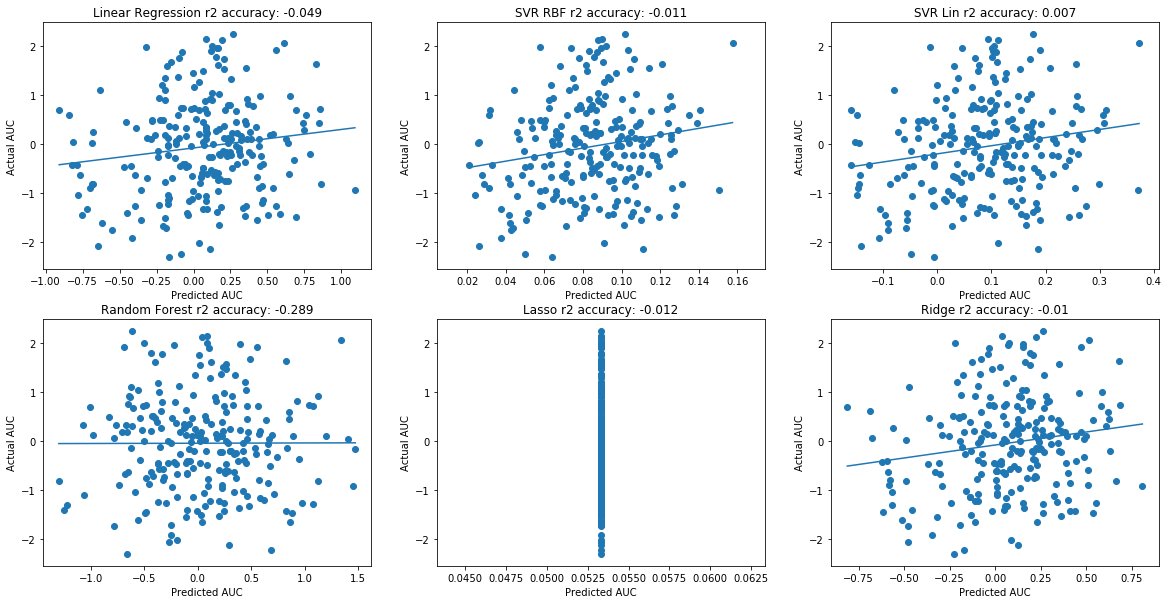

In [100]:
x_train, x_test, y_train, y_test = train_test_split(pca_components_onehot, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
y_pred_linreg_PCA, r2_linreg_PCA = test_model (linreg)
y_pred_svr_rbf_PCA, r2_svr_rbf_PCA = test_model (svr_rbf)
y_pred_svr_lin_PCA, r2_svr_lin_PCA = test_model (svr_lin)
y_pred_rf_PCA, r2_rf_PCA = test_model (rf)
y_pred_lasso_PCA, r2_lasso_PCA = test_model (lasso)
y_pred_ridge_PCA, r2_ridge_PCA = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], y_pred_linreg_PCA, "Linear Regression", r2_linreg_PCA)
ax[0,1] = draw_plot (ax[0,1], y_pred_svr_rbf_PCA, "SVR RBF", r2_svr_rbf_PCA)
ax[0,2] = draw_plot (ax[0,2], y_pred_svr_lin_PCA, "SVR Lin", r2_svr_lin_PCA)
ax[1,0] = draw_plot (ax[1,0], y_pred_rf_PCA, "Random Forest", r2_rf_PCA)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_PCA, "Lasso", r2_lasso_PCA)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_PCA, "Ridge", r2_ridge_PCA)

/Users/christine/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


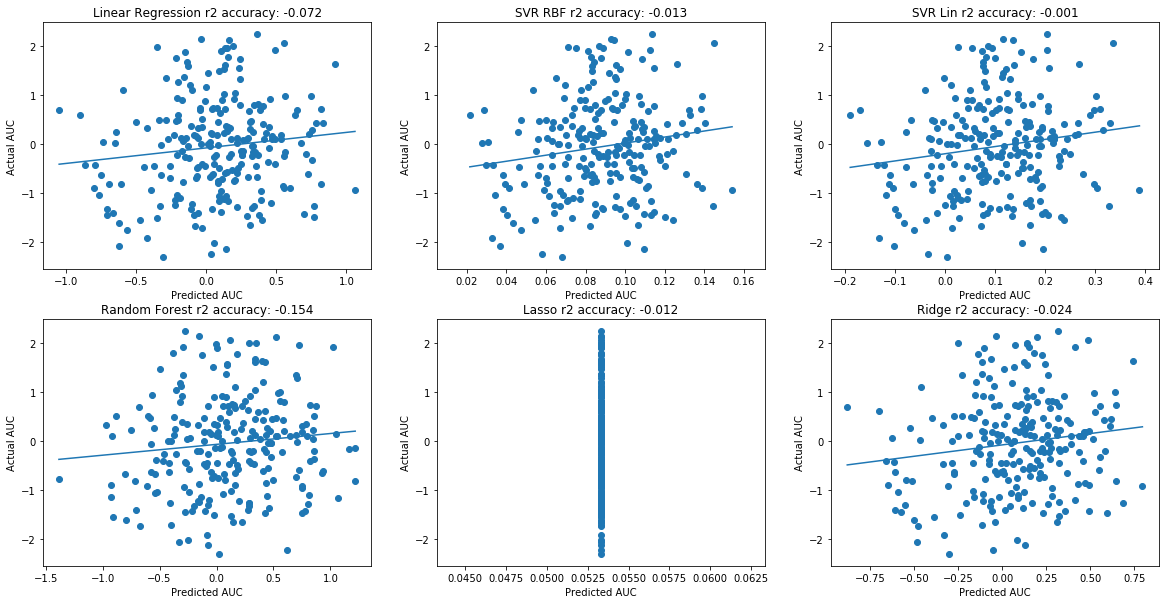

In [101]:
x_train, x_test, y_train, y_test = train_test_split(pca_components_binary, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
y_pred_linreg_PCA_binary, r2_linreg_PCA_binary = test_model (linreg)
y_pred_svr_rbf_PCA_binary, r2_svr_rbf_PCA_binary = test_model (svr_rbf)
y_pred_svr_lin_PCA_binary, r2_svr_lin_PCA_binary = test_model (svr_lin)
y_pred_rf_PCA_binary, r2_rf_PCA_binary = test_model (rf)
y_pred_lasso_PCA_binary, r2_lasso_PCA_binary = test_model (lasso)
y_pred_ridge_PCA_binary, r2_ridge_PCA_binary = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], y_pred_linreg_PCA_binary, "Linear Regression", r2_linreg_PCA_binary)
ax[0,1] = draw_plot (ax[0,1], y_pred_svr_rbf_PCA_binary, "SVR RBF", r2_svr_rbf_PCA_binary)
ax[0,2] = draw_plot (ax[0,2], y_pred_svr_lin_PCA_binary, "SVR Lin", r2_svr_lin_PCA_binary)
ax[1,0] = draw_plot (ax[1,0], y_pred_rf_PCA_binary, "Random Forest", r2_rf_PCA_binary)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_PCA_binary, "Lasso", r2_lasso_PCA_binary)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_PCA_binary, "Ridge", r2_ridge_PCA_binary)

In [102]:
score_df = pd.DataFrame({'Linear Regression': [r2_linreg, r2_linreg_binary, r2_linreg_mut, r2_linreg_mut_binary, r2_linreg_cn, r2_linreg_cn_binary, r2_linreg_PCA, r2_linreg_PCA_binary],
                         'SVM RBF': [r2_svr_rbf,r2_svr_rbf_binary, r2_svr_rbf_mut, r2_svr_rbf_mut_binary, r2_svr_rbf_cn, r2_svr_rbf_cn_binary, r2_svr_rbf_PCA, r2_svr_rbf_PCA_binary],
                         'SVM Linear': [r2_svr_lin, r2_svr_lin_binary, r2_svr_lin_mut, r2_svr_lin_mut_binary, r2_svr_lin_cn, r2_svr_lin_cn_binary, r2_svr_lin_PCA, r2_svr_lin_PCA_binary],
                         'Random Forest': [r2_rf, r2_rf_binary, r2_rf_mut, r2_rf_mut_binary, r2_rf_cn, r2_rf_cn_binary, r2_rf_PCA, r2_rf_PCA_binary],
                         'Lasso': [r2_lasso, r2_lasso_binary, r2_lasso_mut, r2_lasso_mut_binary, r2_lasso_cn, r2_lasso_cn_binary, r2_lasso_PCA, r2_lasso_PCA_binary],
                         'Ridge': [r2_ridge, r2_ridge_binary, r2_ridge_mut, r2_ridge_mut_binary, r2_ridge_cn, r2_ridge_cn_binary, r2_ridge_PCA, r2_ridge_PCA_binary]}, 
                       index=["All", "All Binary", "Mutation Only","Mutation Binary", "Copy Number Only", "Copy Number Binary", "PCA", "PCA Binary"])
score_df

,Lasso,Linear Regression,Random Forest,Ridge,SVM Linear,SVM RBF
All,-0.056395,-5.196603e-01,-0.119126,-0.519796,-0.037146,-0.037146
All Binary,-0.060803,-4.991153e-01,-0.105745,-0.498250,-0.425259,-0.036263
Mutation Only,-0.046157,-9.411269e+25,-0.215257,-3.341939,-3.106120,-0.104806
Mutation Binary,-0.032762,-1.208084e+26,-0.073050,-0.939399,-0.766925,-0.087409
Copy Number Only,-0.034748,-7.040443e-01,-0.091308,-0.703821,-0.624684,-0.027826
Copy Number Binary,-0.021595,-6.712069e-01,-0.015573,-0.671128,-0.596222,-0.027138
PCA,-0.011782,-4.888766e-02,-0.289187,-0.009806,0.007329,-0.010693
PCA Binary,-0.011782,-7.194234e-02,-0.154412,-0.024041,-0.001055,-0.013140
